In [2]:
#hide
from IPython.display import HTML
import matplotlib.pyplot as plt
import proplot as plot
plot.rc['figure.facecolor'] = 'white'
plot.rc['axes.grid'] = False
plot.rc['lines.markeredgewidth'] = 0
plot.rc['image.cmap'] = 'PiYG'

# Authorship identification
- toc: true 
- badges: false
- comments: true
- categories: [stylometry, machine learning, natural language processing]

In 2020 I was able to take a few courses in the grad computer science department; the first was Data Mining and the second was Intro to Machine Learning. I thought should write about a few of the things I learned. One application of machine learning which I focused on is the task of *authorship identification*, that is, to identify the author of an unlabeled document given a list of possible authors and some sample of each author's writing. To learn about this topic, I attempted to reproduce the results presented in a paper titled *N-Gram Feature Selection for Authorship Identification* which can be found [here](https://www.researchgate.net/publication/221655968_N-Gram_Feature_Selection_for_Authorship_Identification). In this post I'll first motivate the problem of authorship identification, then briefly introduce the relevant statistical methods, and finally summarize and implement the methods in the paper.

<img src=images_next/task.png width=600>

### Stylometry

#### Motivation: the Federalist Papers

The Federalist Papers are an important collection of 85 essays written by Hamilton, Madison, and Jay during 1787 and 1788. They were published under the alias "Plubious" at the time, and although it became well known that the three contributed to papers, the authorship of each individual paper was kept hidden for over a decade. It was actually in the interest Hamilton and Madison, both politicians, to keep the authorship a secret (they had both changed their position on a number of issues and didn't want their political opponents to use their old arguments against them). Days before his death, however, Hamilton allegedly wrote down who he believed to be the correct author of each essay, claiming over 60 for himself. Madison waited a number of years before publishing his own list, and in the end there were 12 essays to which both Madison and Hamilton claimed authorship. Many interesting details on the controversy can be found in a paper by [Adair](https://www.jstor.org/stable/1921883?read-now=1&seq=23#page_scan_tab_contents).

<img src=images_next/Hamilton_and_Madison.png width=550>
<figcaption>Alexander Hamilton (left) and James Madison (right). Credit: Wikipedia.</figcaption>

There are two ways we could go about resolving this dispute. The first approach is to analyze the actual *content* of the text. For example, perhaps an essay draws from a reference which only Madison was intimately familiar with, or perhaps an essay is similar to some previous work by Hamilton. This was done many times over the next 150 years, but perhaps the final word on the subject was by Adair in 1944, who concluded that Madison likely wrote all 12 essays. An alternative approach is to determine the authorship using only the words on the page, i.e., to analyze the *style* of the text. For example, maybe Madison used many more commas than Hamilton. The field of *stylometry* attempts to statistically quantify these stylistic differences. David Holmes writes the following about stylometry:
> *At its heart lies an assumption that authors have an unconscious aspect to their style, an aspect which cannot consciously be manipulated but which possesses features which are quantifiable and which may be distinctive.*

I think this a valid assumption. The question is which features best characterize the author's style and which methods are best to use in the analysis of these features. Let's go back in time a bit to the first attempts at stylometry. 

#### History

[Thomas Mendenhall](https://en.wikipedia.org/wiki/Thomas_Corwin_Mendenhall), a physicist, is considered the first to statistically analyze large literary texts. He presented the following interesting idea in an 1887 paper titled [*The Characteristic Curves of Composition*](https://www.jstor.org/stable/pdf/1764604.pdf): it is well-known that each element has a unique distribution of wavelengths in the light which it emits when it is heated; perhaps each author has a unique distribution of word lengths in the texts they have written. It's a really cool idea, and I highly recommend reading his original paper. Mendenhall tallied word lengths by hand for various books, usually in batches of 1000 words or so. Here is Fig. 2 from his paper which shows the characteristic curves for a few excerpts of *Oliver Twist*.

<img src=images_next/Mendenhall_Fig2.png width=400>
<figcaption>Distribution of word lengths in "Oliver Twist". Each curve is for a different sample of 1000 words.</figcaption>

He showed that these curves are very interesting and that they do show similarities between different works by the same author. The use of these statistics for authorship identification was left for future work. 

The next significant advance in the statistical analysis of text was made by Zipf in 1932. Zipf found an interesting relationship between an integer $k$ and the frequency $f(k)$ of the $k$th most frequent word. This is often called a *rank-frequency* relationship where $k$ is the rank. The scaling law can be written as

$$ f(k) \propto k^{-1}. \tag{1}$$

The basic idea expressed by this power law is that short words are much more frequent than large words. Surprisingly, the law holds up very well, albeit not perfectly, for most texts. *Why* this is the case is still unknown; a comprehensive review of the current state of the law can be found [here](https://link.springer.com/article/10.3758/s13423-014-0585-6). The law also shows up in other situations such as national GDP:

<img src=images_next/Cristelli_Fig1_big.png width=500>
<figcaption>Zipf’s Law for National GDPs over time, which appear to be moving toward the prediction by Zipf's Law (red line). From Ref. [1].</figcaption>

Although not directly applicable to authorship identification, the success of Zipf's Law was very encouraging and led to a flurry of new mathematical models in the following years. Stylometry had a landmark case in the 1960's when researchers used the frequency distributions of short function words — words we don't think about too much like "upon" or "therefore" — to support Adair's conclusion that Madison wrote the 12 disputed Federalist Papers. 

At the end of the day, however, models created in the spirit of Zipf's Law are probably doomed to fail. The "true" underlying model must be very complex due to its dependence on human psychology. There are now many algorithms available which instead build predictive models directly from data, and these can be readily applied to the problem of authorship identification. Here we focus on the use of the Support Vector Machine (SVM).

### Support Vector Machine (SVM)

I include here the basic idea behind the SVM approach. There are, of course, a huge number of resources which go into the details [include the references]. I'll sort of follow the Wikipedia page since it has a nice short summary.

#### Maximum margin hyperplane

Consider a linear, binary classifier, i.e., a plane which splits the data into two classes. The equation for a plane in any number of dimensions is 

$$ y(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + w_0 = 0 \tag{2}. $$

This plane is called the *decision surface*; points are assigned to class 1 if $y(\mathbf{x}) > 0$ or class 2 when $y(\mathbf{x}) < 0$. Suppose the data is linearly separable (able to be completely split in two) and that we've found a plane which correctly splits the data. We could then scale the coordinates such that all points with $y(\mathbf{x}) \ge 1$ belong to class 1 and all points with $y(\mathbf{x}) \le -1$ belong to class 2. The separating plane then sits in the middle as in the following figure.

<img src=images_next/svm.png width=300>
<figcaption>Maximum margin separating plane. Credit: Wikipedia.</figcaption>

Notice that the plane could be rotated while still correctly splitting the existing data; the SVM attempts to find the optimal plane by maximizing the orthogonal distance from the decision plane to the closest point. This is known as the *margin*, and it can be shown that it is inversely proportional to the magnitude of $\mathbf{w}$. Thus, the SVM tries to minimize $|\mathbf{w}|^2$ subject to the constraint that all points are correctly categorized. New data is then assigned based on this optimal boundary.

Many datasets won't be linear separable. In this case there are two options for the SVM. The first is to add a penalty function in order to minimize the number of miscategorized points, so for *N* samples we minimize

$$ \frac{1}{2}|\mathbf{w}|^2 +  C\sum_{i=1}^{N}{\Theta\left[{t_i y(\mathbf{x}_i)}\right]} . \tag{3}$$

where $t_i$ is the true class of point $i$, $\Theta$ is the Heaviside step function, and $C$ is a positive constant. Let's try this on some toy data. The Python package [scikit-learn](https://scikit-learn.org/stable/modules/svm.html) has a user-friendly interface for the SVM implementation in [LIBLINEAR](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) which we use here.

In [3]:
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
import proplot as plot
import plotly.graph_objects as go

To do: add legend class1/2.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


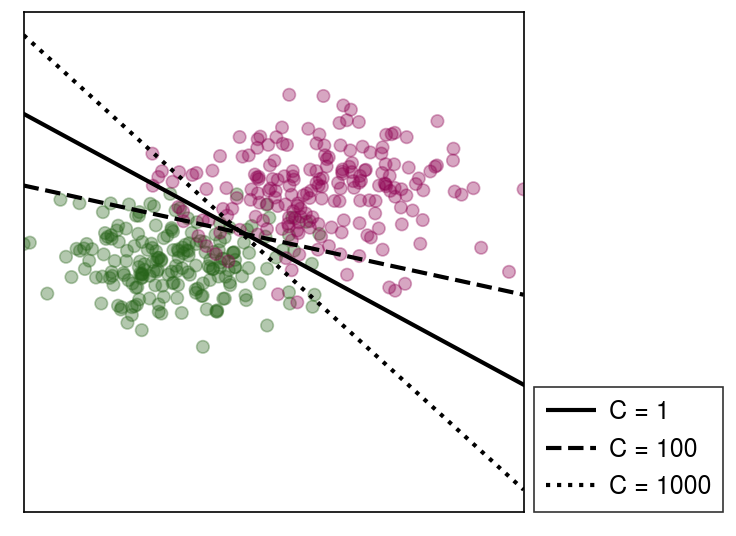

In [4]:

# Create two overlapping Gaussian distributions
np.random.seed(0)
n = 200
X = np.vstack([np.random.normal(size=(n, 2), loc=[0, 0], scale=2.0),
               np.random.normal(size=(n, 2), loc=[5, 5], scale=2.5)])
y = n * [1] + n * [-1] 

# Plot the data
fig, ax = plot.subplots()
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y)

# Plot decision boundary for different values of C
C_vals = [1, 100, 1000]
line_x = np.array([min(X[:, 0]), max(X[:, 0])])
for C, ls in zip(C_vals, ['solid', 'dashed', 'dotted']):
    clf = svm.LinearSVC(C=C)
    clf.fit(X, y)
    (w1, w2), w0 = clf.coef_[0], clf.intercept_
    line_y = -(w1 / w2) * line_x - (w0 / w2)
    ax.plot(line_x, line_y, c='k', ls=ls)
ax.legend(labels=['C = {}'.format(C) for C in C_vals], ncols=1, loc=(1.02, 0))
ax.format(xticks=[], yticks=[], xlim=line_x);

The three lines have significantly different angles, but all have around the same classification accuracy on the existing data. It can therefore be important to try at least a few different values of $C$, which determines the trade-off between correctly classifying all samples and maximizing the margin, and to observe the effect on the testing data classification accuracy. $C$ is known as a *hyperparameter* since it isn't changed by the algorithm during the training process, but is instead a property of the algorithm itself.

#### Kernel trick

In some cases the linear model is going to be bad; a frequently used example is following "target" dataset.

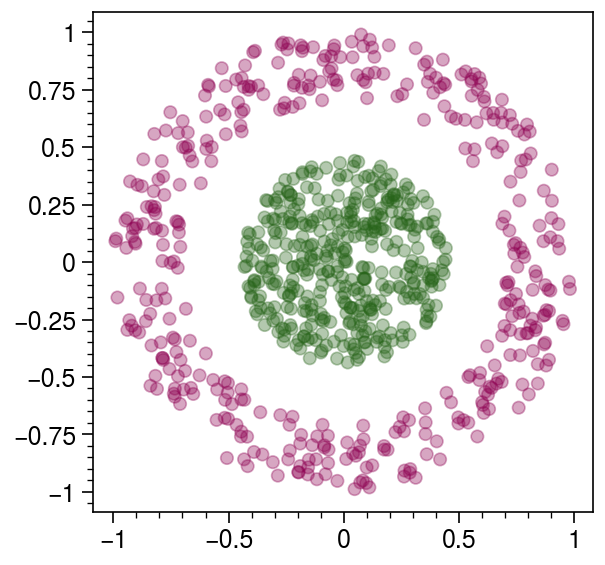

In [5]:
n = 400
r1 = np.sqrt(np.random.uniform(0.0, 0.2, size=(n,)))
r2 = np.sqrt(np.random.uniform(0.5, 1.0, size=(n,)))
t1 = np.random.uniform(0, 2*np.pi, size=(n,))
t2 = np.random.uniform(0, 2*np.pi, size=(n,))
X = np.vstack([np.vstack([r1*np.cos(t1), r1*np.sin(t1)]).T,
               np.vstack([r2*np.cos(t2), r2*np.sin(t2)]).T])
y = n * [1] + n * [-1]

fig, ax = plot.subplots()
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y);

Obviously a line won't work; ideally we would draw a circle around the inner cluster to split the data. A really cool strategy is the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method), which performs a transformation to a higher dimensional space in which the data is linearly separable. For example, consider the transformation

$$ (x_1, x_2) \rightarrow (x_1^2, x_2^2, x_1^2 + x_2^2) . \tag{4}$$

In [6]:
x1, x2 = X.T
u = x1**2
v = np.sqrt(2) * x1 * x2
w = x2**2
fig = go.Figure(data=go.Scatter3d(x=u, y=v, z=w, mode='markers', 
                                  marker=dict(color=y, size=5, opacity=0.5)))
HTML(fig.to_html(include_plotlyjs='cdn'))

We can now split the data with a 2D plane! This need not be the transformation used by the SVM — in fact, many transformations can be used — but it clearly demonstrates the idea. Once the decision boundary is found in this transormed space, it can be projected back onto our original space. A quick way to plot this boundary is to make a prediction on a grid of points which covers the entire plot range.

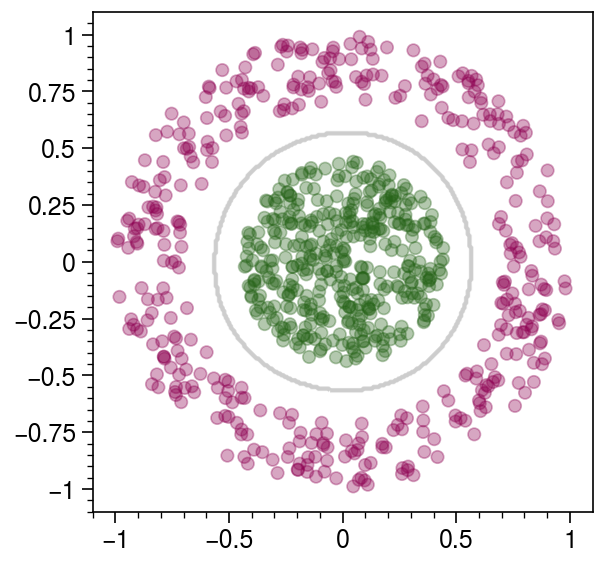

In [7]:
clf = svm.SVC(kernel='rbf')
clf.fit(X, y)

xx, yy = np.meshgrid(np.linspace(-1.1, 1.1, 300), np.linspace(-1.1, 1.1, 300))
Z = np.c_[xx.ravel(), yy.ravel()]
y_pred = clf.predict(Z)
zz = y_pred.reshape(xx.shape)

fig, ax = plot.subplots()
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y)
ax.contour(xx, yy, zz, alpha=0.05, cmap='binary');

There are, however, several advantages to the linear SVM. First, it is much faster to train, and second, the kernel trick may be unnecessary for high-dimensional data. As we'll see, the latter applies to the task of authorship identification.

#### Multi-class 

The two-class problem can be extended to multi-class problems. [Overview of method.] 

### N-grams and feature selection methods 

As I mentioned in the introduction, the paper I chose to follow to learn about this topic is called *N-Gram Feature Selection for Authorship Identification*. In short, the paper used *n-gram* frequencies (which I'll define shortly) as features in the classification task and developed a new method to select the best subset of these features. Let's step through their method.

#### Data set description 

The Reuters Corpus Volume 1 (RCV1) data set is a huge collection of news articles, each manually labeled by topic. Around 100,000 of these have known authors, and there are around 2000 different authors. A specific topic was chosen, and only authors who wrote at least one article which fell under this topic were considered. From this subset of authors, the top 50 in terms of number of articles written were chosen. 100 articles from each author were selected — 5000 in total — and these were evenly split into a training and testing set. The resulting corpus is a good challenge for authorship identification because 1) the genre of all the documents is the same, and 2) the authors write about similar topics. Hopefully this leaves the author's style as the primary distinguishing factor. Another challenge is that the documents are quite short. The data set can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/Reuter_50_50). 

On my machine the files are organized as follows:

<img src=images_next/files.png width=600>

Let's create a list of strings corresponding to the 2500 training documents. Each document is represented as a single string with spaces and new lines replaced with underscores. We also need to keep track of the correct label  for each document.

In [51]:
from os import listdir
from os.path import join

def load_file(filename):
    string = open(filename, 'r').read()
    for c in (' ', '\n'):
        string = string.replace(c, '_')
    return string


def load_files(outer_path):
    texts, class_ids, author_names = [], [], []
    for class_id, folder in enumerate(sorted(listdir(outer_path))):
        author_names.append(folder)
        folder_path = join(outer_path, folder)
        for filename in listdir(folder_path):
            class_ids.append(class_id)
            filename = join(folder_path, filename)
            file = open(filename, 'r')
            text = file.read()
            for c in ('\n', ' '):
                text = text.replace(c, '_')
            texts.append(text)
            file.close()
    return texts, class_ids, author_names

texts_train, y_train, author_names = load_files('reuters_data/train')
texts_test, y_test, _ = load_files('reuters_data/train')
print(texts_train[0])

A_group_of_leading_trademark_specialists_plans_to_release_recommendations_aimed_at_minimizing_disputes_over_Internet_address_names._The_International_Trademark_Association_is_working_on_a_white_paper_that_will_be_completed_in_the_next_few_months,_David_Maher,_co-chair_of_the_association's_Internet_issues_committee,_said_in_a_telephone_interview._


#### N-grams

An obvious feature candidate is word frequency; a less obvious one is *n-gram* frequency. A character n-gram is a string of length *n*. For example, the string *red_bike!* has the following 3-grams: *red*, *ed_*, *d_b*, *_bi*, *bik*, *ike*, *ke!*. The idea behind this approach is that these shorter strings capture different aspects of style such as use of punctuation and certain prefixes/suffixes. Let's create a function to exctract the raw n-gram frequencies from the texts.

In [ ]:
class FeatureExtractor:
    def __init__(self):
        self.vocab = None
        
    def get_ngrams(self, text, n):
        if n < 1 or n > len(text):
            return []
        return [text[i-n:i] for i in range(n, len(text) + 1)]
        
    def build_dict(self, texts, nmin=1, nmax=1):
        self.vocab = {}
        for ngram in self.get_ngrams(text, n)
            ngrams = 
        
    def get_feature_matrix(self, texts):

In [50]:
def get_ngrams(text, n=1):
    if n < 1 or n > len(texts):
        return []
    ngrams = [text[i-n:i] for i in range(n, len(text) + 1)]


n = 4
text = texts_train[0]
ngram_freqs = get_ngram_freqs(text, n)
ngrams, counts = list(ngram_freqs.keys()), list(ngram_freqs.values())



['A_gr',
 '_gro',
 'grou',
 'roup',
 'oup_',
 'up_o',
 'p_of',
 '_of_',
 'of_l',
 'f_le',
 '_lea',
 'lead',
 'eadi',
 'adin',
 'ding',
 'ing_',
 'ng_t',
 'g_tr',
 '_tra',
 'trad',
 'rade',
 'adem',
 'dema',
 'emar',
 'mark',
 'ark_',
 'rk_s',
 'k_sp',
 '_spe',
 'spec',
 'peci',
 'ecia',
 'cial',
 'iali',
 'alis',
 'list',
 'ists',
 'sts_',
 'ts_p',
 's_pl',
 '_pla',
 'plan',
 'lans',
 'ans_',
 'ns_t',
 's_to',
 '_to_',
 'to_r',
 'o_re',
 '_rel',
 'rele',
 'elea',
 'leas',
 'ease',
 'ase_',
 'se_r',
 'e_re',
 '_rec',
 'reco',
 'ecom',
 'comm',
 'omme',
 'mmen',
 'mend',
 'enda',
 'ndat',
 'dati',
 'atio',
 'tion',
 'ions',
 'ons_',
 'ns_a',
 's_ai',
 '_aim',
 'aime',
 'imed',
 'med_',
 'ed_a',
 'd_at',
 '_at_',
 'at_m',
 't_mi',
 '_min',
 'mini',
 'inim',
 'nimi',
 'imiz',
 'mizi',
 'izin',
 'zing',
 'ng_d',
 'g_di',
 '_dis',
 'disp',
 'ispu',
 'sput',
 'pute',
 'utes',
 'tes_',
 'es_o',
 's_ov',
 '_ove',
 'over',
 'ver_',
 'er_I',
 'r_In',
 '_Int',
 'Inte',
 'nter',
 'tern',
 'erne',
 

In [ ]:
import os

outer_path = 'reuters_data/train'

class_names = []
texts = []
class_ids = []

for class_id, folder in enumerate(sorted(list_folders(outer_path))):
    class_names.append(folder)
    folder_path = os.path.join(outer_path, folder)
    for filename in list_files(folder_path):
        class_ids.append(class_id)
        filename = os.path.join(folder_path, filename)
        text = open(filename, 'r').read()
        for c in ('\n', ' '):
            text = text.replace(c, '_')
        texts.append(text)
        

#### Feature selection

Although proven to be effective, one downside of the n-gram approach is the potentially large dimensionality of the features space relative to word-based approaches. This is especially true if the value of $n$ is not fixed. It is thus advantageous to select a subset of these features which are "best" in some sense. This process is often called *feature selection*.

#### Results

### Conclusion

I think what I'll try next is to identify artists from images of their paintings.